# Harmony EOSS L2SS API Tutorial

## Before you start
Before you beginning this tutorial, make sure you have an account in the Earthdata Login UAT or Production environment, which 
will be used for this notebook by visiting [https://uat.urs.earthdata.nasa.gov](https://uat.urs.earthdata.nasa.gov).
These accounts, as all Earthdata Login accounts, are free to create and only take a moment to set up.

## Set Up Authentication

We need some boilerplate up front to log in to Earthdata Login.  The function below will allow Python
scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine uat.urs.earthdata.nasa.gov
    login <your username>
    password <your password>
    
machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 


In [1]:
from urllib import request
from http.cookiejar import CookieJar
import getpass
import netrc
import json
import requests
import sys
import shutil
import xarray as xr


def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


# GET TOKEN FROM CMR 
def get_token( url: str,client_id: str, user_ip: str,endpoint: str) -> str:
    try:
        token: str = ''
        username, _, password = netrc.netrc().authenticators(endpoint)
        xml: str = """<?xml version='1.0' encoding='utf-8'?>
        <token><username>{}</username><password>{}</password><client_id>{}</client_id>
        <user_ip_address>{}</user_ip_address></token>""".format(username, password, client_id, user_ip)
        headers: Dict = {'Content-Type': 'application/xml','Accept': 'application/json'}
        resp = requests.post(url, headers=headers, data=xml)
        
        response_content: Dict = json.loads(resp.content)
        token = response_content['token']['id']
    except:
        print("Error getting the token - check user name and password", sys.exc_info()[0])
    return token

### Find a granule for subsetting

Below we call out a specific granule (G1226018995-POCUMULUS) on which we will use the podaac L2 subsetter. Finding this information would complicate the tutorial- but po.daac has a tutorial available for using the CMR API to find collections and granules of interest. Please see the following tutorial for that information:

PODAAC_CMR.ipynb


In [2]:
collection = 'C1940473819-POCLOUD'
variable = 'sea_surface_temperature'
venue = 'prod'

In [3]:
# Defaults
cmr_root = 'cmr.earthdata.nasa.gov'
harmony_root = 'https://harmony.earthdata.nasa.gov'
edl_root = 'urs.earthdata.nasa.gov'

In [4]:
if venue == 'uat':
    cmr_root = 'cmr.uat.earthdata.nasa.gov'
    harmony_root = 'https://harmony.uat.earthdata.nasa.gov'
    edl_root = 'uat.urs.earthdata.nasa.gov'

print ("Environments: ")
print ("\t" + cmr_root)
print ("\t" + harmony_root)
print ("\t" + edl_root)

Environments: 
	cmr.earthdata.nasa.gov
	https://harmony.earthdata.nasa.gov
	urs.earthdata.nasa.gov


Now call the above function to set up Earthdata Login for subsequent requests

In [5]:
setup_earthdata_login_auth(edl_root)
token_url="https://"+cmr_root+"/legacy-services/rest/tokens"
token=get_token(token_url,'jupyter', '127.0.0.1',edl_root)

##  Subset of a PO.DAAC Granule

We can now build onto the root URL in order to actually perform a transformation.  The first transformation is a subset of a selected granule.  _At this time, this requires discovering the granule id from CMR_.  That information can then be appended to the root URL and used to call Harmony with the help of the `request` library.

Above we show how to find a granule id for processing.

**Notes:**
  The L2 subsetter current streams the data back to the user, and does not stage data in S3 for redirects. This is functionality we will be adding over time.
  It doesn't work with URS backed files, which is coming in the next few weeks
  it only works on the show dataset, but 
    

In [6]:
cmr_url = "https://"+cmr_root+"/search/granules.umm_json?collection_concept_id="+collection+"&sort_key=-start_date&bounding_box=-90,-45.75,90,-45&token="+token

response = requests.get(cmr_url)

gid=response.json()['items'][0]['meta']['concept-id']
print(response.json()['items'][0])
print(gid)




{'meta': {'concept-type': 'granule', 'concept-id': 'G2156006342-POCLOUD', 'revision-id': 3, 'native-id': '20211101133501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0', 'provider-id': 'POCLOUD', 'format': 'application/vnd.nasa.cmr.umm+json', 'revision-date': '2021-11-01T15:47:25.788Z'}, 'umm': {'TemporalExtent': {'RangeDateTime': {'EndingDateTime': '2021-11-01T13:39:58.000Z', 'BeginningDateTime': '2021-11-01T13:35:01.000Z'}}, 'MetadataSpecification': {'Version': '1.6.3', 'URL': 'https://cdn.earthdata.nasa.gov/umm/granule/v1.6.3', 'Name': 'UMM-G'}, 'GranuleUR': '20211101133501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0', 'ProviderDates': [{'Type': 'Insert', 'Date': '2021-11-01T15:44:39.409Z'}, {'Type': 'Update', 'Date': '2021-11-01T15:44:39.409Z'}], 'SpatialExtent': {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -8.288, 'NorthBoundingCoordinate': -32.997, 'EastBoundingCoordinate': 27.479, 'SouthBoundingCoordinate': -54.501}], 'GPolygons': 

In [7]:
bboxSubsetConfig = {
    'collection_id': collection,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'granuleid': gid,
    'lat': '(-45.75:45)',
    'lon': '(-90:90)'
}
bbox_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleid={granuleid}&subset=lat{lat}&subset=lon{lon}'.format(**bboxSubsetConfig)
print('Request URL', bbox_url)


Request URL https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleid=G2156006342-POCLOUD&subset=lat(-45.75:45)&subset=lon(-90:90)


In [8]:
with request.urlopen(bbox_url) as response, open('ogc_temp.nc', 'wb') as out_file:
    print('Content Size:', response.headers['Content-length'])
    shutil.copyfileobj(response, out_file)
    print("Downloaded request to ogc_temp.nc")

Content Size: 9200361
Downloaded request to ogc_temp.nc


In [9]:
ds = xr.open_dataset('ogc_temp.nc')
ds

lat_var = None
lon_var = None

# Determine the lat/lon coordinate names
for coord_name, coord in ds.coords.items():
    if 'units' not in coord.attrs:
        continue
    if coord.attrs['units'] == 'degrees_north':
        lat_var = coord_name
    if coord.attrs['units'] == 'degrees_east':
        lon_var = coord_name
        
# If the lat/lon coordinates could not be determined, use l2ss-py get_coord_variable_names
if not lat_var or not lon_var:
    from podaac.subsetter import subset
    lat_var_names, lon_var_names = subset.get_coord_variable_names(ds)
    lat_var = lat_var_names[0]
    lon_var = lon_var_names[0]

print(f'lat_var={lat_var}')
print(f'lon_var={lon_var}')

lat_var=lat
lon_var=lon


In [10]:
if ds[variable].size == 0:
    print("No data in subsetted region. Exiting")
    sys.exit(0)

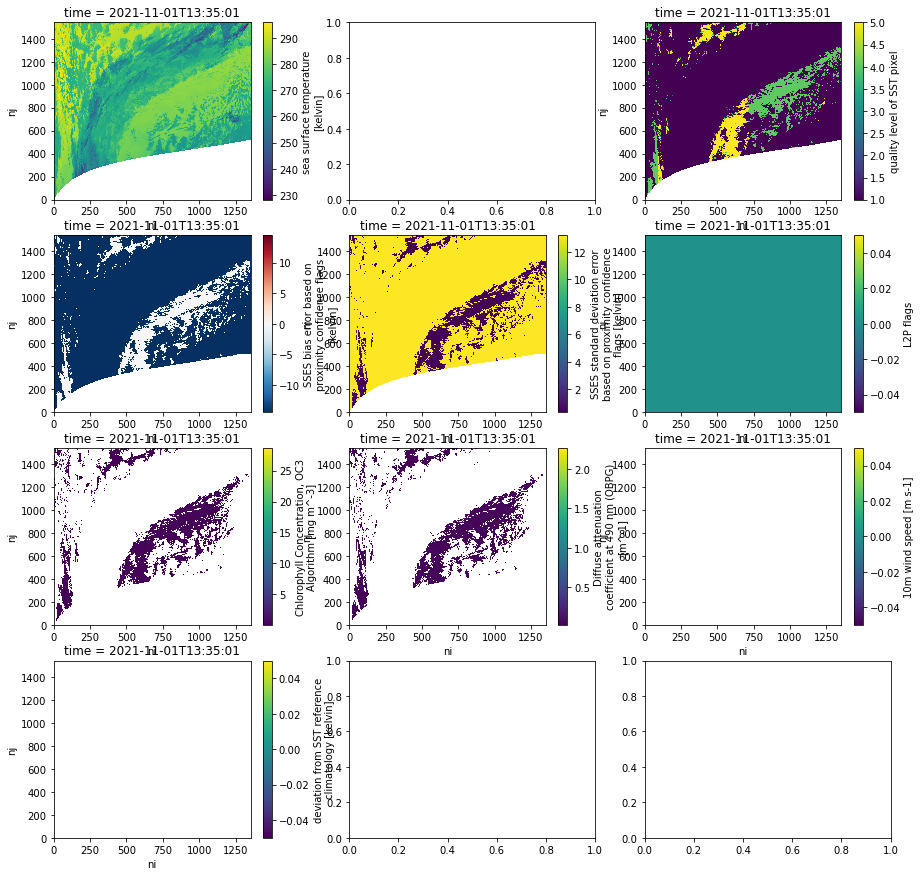

In [11]:
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(ncols=3, nrows=math.ceil((len(ds.data_vars)/3)))
fig.set_size_inches((15,15))

for count, xvar in enumerate(ds.data_vars):
    if  ds[xvar].dtype == "timedelta64[ns]":
        continue
        #ds[xvar].astype('timedelta64[D]').plot(ax=axes[int(count/3)][count%3])
    ds[xvar].plot(ax=axes[int(count/3)][count%3])

## Verify the subsetting worked

Bounds used were: 

  'lat': '(-45.75:45)',
  'lon': '(-90:90)'

In [12]:
var_ds = ds[variable]
msk = xr.ufuncs.logical_not(xr.ufuncs.isnan(var_ds.data.squeeze()))

llat = ds[lat_var].where(msk)
llon = ds[lon_var].where(msk)

lat_max = llat.max()
lat_min = llat.min()

lon_min = llon.min()
lon_max = llon.max()

lon_min = (lon_min + 180) % 360 - 180
lon_max = (lon_max + 180) % 360 - 180

print(lon_min)
print(lon_max)
print(lat_min)
print(lat_max)

if lat_max <= 45 and lat_min >= -45.75:
    print("Successful Latitude subsetting")
elif xr.ufuncs.isnan(lat_max) and xr.ufuncs.isnan(lat_min):
    print("Partial Lat Success - no Data")
else:
    assert False


if lon_max <= 90 and lon_min >= -90:
    print("Successful Longitude subsetting")
elif xr.ufuncs.isnan(lon_max) and xr.ufuncs.isnan(lon_min):
    print("Partial Lon Success - no Data")
else:
    assert False
    

<xarray.DataArray 'lon' ()>
array(-8.2880373)
<xarray.DataArray 'lon' ()>
array(24.4941864)
<xarray.DataArray 'lat' ()>
array(-45.75, dtype=float32)
<xarray.DataArray 'lat' ()>
array(-32.997337, dtype=float32)
Successful Latitude subsetting
Successful Longitude subsetting
